In [1]:
# Read all the annotations in the train table from the lakehouse
df = spark.sql("SELECT * FROM SnapshotSerengeti_LH.train_annotations WHERE train_annotations.category_id > 1")

# filter out the season, sequence ID, category_id snf image_id
df_train = df.select("season", "seq_id", "category_id", "location", "image_id", "datetime")

# remove image_id wiTH null and duplicates
df_train = df_train.filter(df_train.image_id.isNotNull()).dropDuplicates()



StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 3, Finished, Available, Finished)

In [2]:
# Import the required libraries
from pyspark.sql.functions import split, regexp_replace, col

# This splits the seq_id string at '#' and takes the first part.
df_train = df_train.withColumn("season_extracted", split(col("seq_id"), "#").getItem(0))

# Remove the 'SER_' prefix from the extracted season for better readability.
df_train = df_train.withColumn("season_label", regexp_replace(col("season_extracted"), "SER_", ""))

# Group by the season_label and count the number of sequences for each season, then order the results.
df_counts = df_train.groupBy("season_label").count().orderBy("season_label")

# visualize the spark data frame directly in the notebook
display(df_counts)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 6d5535e5-a271-4587-b4ce-8c29fa0eed79)

In [3]:
from pyspark.sql import functions as F

# Compute the number of images per sequence.
seq_counts = df_train.groupBy("seq_id").count()

# Aggregate the data: group by the image count and count how many sequences have that count.
sequence_length_counts = (seq_counts
    .groupBy("count")
    .agg(F.count("seq_id").alias("Count of sequences"))
    .withColumnRenamed("count", "Number of images")
    .orderBy(F.col("Number of images"))
)

# visualize the spark data frame directly in the notebook
display(sequence_length_counts)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b2199b58-535e-4fc4-b323-e85d8d2eddd2)

In [4]:
from pyspark.sql.functions import concat, lit

def transform_image_data(df, categories_df):
    """
    Joins the input DataFrame with the categories DataFrame, renames columns,
    and appends a '.JPG' extension to the filename column.
    """
    # Join on category_id to map category names. The join brings the category name as "name", which we then rename to "label".
    df = df.join(
        categories_df.select(col("id").alias("category_id"), col("name")),
        on="category_id",
        how="left"
    ).withColumnRenamed("name", "label")

    # Drop the 'category_id' column
    df = df.drop("category_id")

    # Rename 'image_id' to 'filename'
    df = df.withColumnRenamed("image_id", "filename")

    # Append '.JPG' to the filename
    df = df.withColumn("filename", concat(col("filename"), lit(".JPG")))

    return df

# Load the categories table as a Spark DataFrame
categories_df = spark.sql("SELECT * FROM SnapshotSerengeti_LH.categories")

# Apply trsnaformation for image data
df_train = transform_image_data(df_train, categories_df)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 9, Finished, Available, Finished)

In [5]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Define a window partitioned by seq_id and ordered by filename
windowSpec = Window.partitionBy("seq_id").orderBy("filename")

# Assign a row number to each row within its sequence, filter for the first frame, then drop the helper column.
df_train = df_train.withColumn("row_num", row_number().over(windowSpec)) \
                   .filter(col("row_num") == 1) \
                   .drop("row_num")

# Count the rows in the resulting DataFrame
df_train.count()


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 10, Finished, Available, Finished)

589758

In [6]:
# Create a new DataFrame that counts the number of images per label
label_counts = df_train.groupBy("label").count().orderBy(col("count").desc())

# Rename the columns for better readability and visualization
label_counts = label_counts.withColumnRenamed("label", "Label") \
                           .withColumnRenamed("count", "Number of images")

# Visualize the label counts
display(label_counts)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 11, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, dadd5c31-f844-4ca4-870a-f29885124dce)

In [7]:
def get_ImageUrl(filename):
    return f"https://lilawildlife.blob.core.windows.net/lila-wildlife/snapshotserengeti-unzipped/{filename}"


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 12, Finished, Available, Finished)

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Create a UDF from the function
get_ImageUrl_udf = udf(get_ImageUrl, StringType())

# Apply the UDF to create the image_url column
df_train = df_train.withColumn("image_url", get_ImageUrl_udf(col("filename")))


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 13, Finished, Available, Finished)

In [9]:
import urllib.request
import matplotlib.pyplot as plt

def display_random_image(label, random_state, width=500):
    # Filter the Spark DataFrame to only include rows with the specified label,
    # then order randomly (using the provided seed) and select one row.
    row = df_train.filter(col("label") == label) \
                  .orderBy(F.rand(random_state)) \
                  .limit(1) \
                  .collect()[0]
    
    # Get the image URL from the selected row and display the image
    url = row["image_url"]
    download_and_display_image(url, label)

def download_and_display_image(url, label):
    image = plt.imread(urllib.request.urlopen(url), format='jpg')
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 14, Finished, Available, Finished)

StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 15, Finished, Available, Finished)

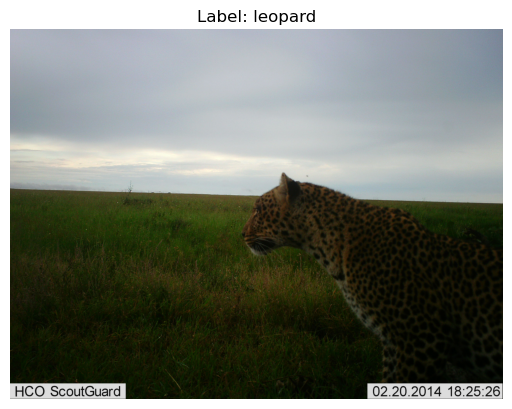

In [10]:
display_random_image(label='leopard', random_state=12)


In [11]:
def proportional_allocation_percentage(df, percentage):
    """
    Proportionally allocate a sample of 'percentage'% of df across label, season, location
    """
    # Determine the total number of rows and desired sample size
    total_count = df.count()
    sample_size = int(round(total_count * (percentage / 100.0)))

    # Compute group counts
    group_counts = (
        df.groupBy("label", "season", "location")
          .count()  # number of rows in each group
          .withColumnRenamed("count", "group_count")
    )

    # Compute the proportion of each group, then approximate "sample_needed" via rounding
    group_counts = (
        group_counts
        .withColumn("proportion", F.col("group_count") / F.lit(total_count))
        .withColumn("sample_needed", F.round(F.col("proportion") * sample_size).cast("int"))
    )

    #  Collect just the group-level info to the driver for fine-grained adjustment
    group_counts_pd = group_counts.select(
        "label", "season", "location", "group_count", "sample_needed", "proportion"
    ).toPandas()

    # Sum of "sample_needed" might not equal the total desired sample_size due to rounding
    current_sum = group_counts_pd["sample_needed"].sum()
    difference = sample_size - current_sum

    if difference > 0:
        # If we're short, we add +1 to the groups with the largest proportions until we fix the difference
        # Sort descending by proportion
        group_counts_pd = group_counts_pd.sort_values("proportion", ascending=False)
        for i in range(difference):
            group_counts_pd.iat[i, group_counts_pd.columns.get_loc("sample_needed")] += 1
        # Re-sort back if desired
        group_counts_pd = group_counts_pd.sort_values(["label", "season", "location"])
    elif difference < 0:
        # If we have too many, subtract 1 from the groups with the smallest proportions
        # Sort ascending by proportion
        group_counts_pd = group_counts_pd.sort_values("proportion", ascending=True)
        for i in range(abs(difference)):
            group_counts_pd.iat[i, group_counts_pd.columns.get_loc("sample_needed")] -= 1
        # Re-sort back if desired
        group_counts_pd = group_counts_pd.sort_values(["label", "season", "location"])

    # Create a Spark DataFrame of the final sample allocations
    allocations_sdf = spark.createDataFrame(group_counts_pd)

    #  Join the allocations back to the main DataFrame so each row knows how many rows 
    #    from its group we want to keep
    df_joined = (
        df.join(
            F.broadcast(allocations_sdf),
            on=["label", "season", "location"],
            how="left"
        )
    )

    # Use a row_number partitioned by (label, season, location) to limit how many rows per group
    window_spec = Window.partitionBy("label", "season", "location").orderBy(F.monotonically_increasing_id())
    df_with_rn = df_joined.withColumn("rn", F.row_number().over(window_spec))

    # Filter out rows where 'rn' exceeds 'sample_needed'
    df_sample = df_with_rn.filter(F.col("rn") <= F.col("sample_needed"))

    # Drop helper columns if you don't need them in the final result
    df_sample = df_sample.drop("proportion", "group_count", "sample_needed", "rn")

    return df_sample


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 16, Finished, Available, Finished)

In [12]:
percent = 0.05
sampled_train = proportional_allocation_percentage(df_train, percent)

# Group by the season_label and count the number of sequences for each season, then order the results.
df_sampled_train_counts = sampled_train.groupBy("season_label").count().orderBy("season_label")

# visualize the spark data frame directly in the notebook
display(df_sampled_train_counts)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 17, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 0d7d5771-2e8a-4738-837f-165ca3ead398)

In [13]:
import urllib.request
from PIL import Image
import os

def download_and_resize_image(url, path, kind):
    filename = os.path.basename(path)
    directory = os.path.dirname(path)

    # Define a new directory path where permission is granted
    directory_path = f'/lakehouse/default/Files/images/{kind}/{directory}/'

    # Create the directory if it does not exist
    os.makedirs(directory_path, exist_ok=True)

    # Define the full target file path
    target_file_path = os.path.join(directory_path, filename)

    # Check if file already exists
    if os.path.isfile(target_file_path):
        return

    # Download the image
    urllib.request.urlretrieve(url, target_file_path)

    # Open the image using PIL
    img = Image.open(target_file_path)

    # Resize the image to a reasonable ML training size
    resized_img = img.resize((224, 224), Image.ANTIALIAS)

    # Save the resized image to a defined filepath
    resized_img.save(target_file_path)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 18, Finished, Available, Finished)

In [14]:
import concurrent.futures

def execute_parallel_download(spark_df, kind):
    df = spark_df.toPandas()
    # Use a process pool instead of a thread pool to avoid thread safety issues
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Batch process images instead of processing them one at a time
        urls = df['image_url'].tolist()
        paths = df['filename'].tolist()
        futures = [executor.submit(download_and_resize_image, url, path, kind) for url, path in zip(urls, paths)]
        # Wait for all tasks to complete
        concurrent.futures.wait(futures)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 19, Finished, Available, Finished)

In [15]:
df_test = spark.sql("SELECT * FROM SnapshotSerengeti_LH.test_annotations WHERE test_annotations.category_id > 1")


df_test = (
    df_test
    .filter(df_test.image_id.isNotNull())
    .dropDuplicates()
    .withColumn("season_extracted", split(col("seq_id"), "#").getItem(0))
    .withColumn("season_label", regexp_replace(col("season_extracted"), "SER_", "")))

df_test = transform_image_data(df_test, categories_df)
df_test = df_test.withColumn("image_url", get_ImageUrl_udf(col("filename")))

sampled_test = proportional_allocation_percentage(df_test, 0.27)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 20, Finished, Available, Finished)

In [16]:
import os

execute_parallel_download(sampled_train, 'train')
execute_parallel_download(sampled_test, 'test')


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 21, Finished, Available, Finished)

In [17]:
import os

def list_all_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

train_images_path = f"/lakehouse/default/Files/images/train/"
test_images_path =  f"/lakehouse/default/Files/images/test/"

print(f"{len(list_all_files(train_images_path))} files downloaded out of {sampled_train.count()}")
print(f"{len(list_all_files(test_images_path))} files downloaded out of {sampled_test.count()}")


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 22, Finished, Available, Finished)

295 files downloaded out of 295
394 files downloaded out of 394


In [18]:
# Drop all columns except filename and label and save to a delta table for train data
sampled_train.select("filename", "label")\
    .write.saveAsTable("sampled_train", mode="overwrite", overwriteSchema="true")

# Drop all columns except filename and label and save to a delta table for test data
sampled_test.select("filename", "label")\
    .write.saveAsTable("sampled_test", mode="overwrite", overwriteSchema="true")


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 23, Finished, Available, Finished)

In [19]:
%pip install torchvision


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 28, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 123.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 125.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 96.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 22.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 62.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 32.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [20]:
import pandas as pd

# load our data 
train_df = spark.sql("SELECT * FROM SnapshotSerengeti_LH.sampled_train")

# convert train_df to pandas dataframe
train_df = train_df.toPandas()


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 30, Finished, Available, Finished)

In [21]:
# Create a new column in the dataframe 
train_df['image_url'] = train_df['filename'].apply(lambda filename: f"/lakehouse/default/Files/images/train/{filename}")

train_df.head()


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 31, Finished, Available, Finished)

filename            label  \
0  S1/D06/D06_R1/S1_D06_R1_PICT1558.JPG  gazellethomsons   
1  S1/R12/R12_R1/S1_R12_R1_PICT0485.JPG  gazellethomsons   
2  S2/H04/H04_R3/S2_H04_R3_PICT0300.JPG  gazellethomsons   
3  S2/H07/H07_R2/S2_H07_R2_PICT1508.JPG  gazellethomsons   
4  S5/D10/D10_R1/S5_D10_R1_IMAG2878.JPG  gazellethomsons   

                                           image_url  
0  /lakehouse/default/Files/images/train/S1/D06/D...  
1  /lakehouse/default/Files/images/train/S1/R12/R...  
2  /lakehouse/default/Files/images/train/S2/H04/H...  
3  /lakehouse/default/Files/images/train/S2/H07/H...  
4  /lakehouse/default/Files/images/train/S5/D10/D...

In [22]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder to the label column in the train_df DataFrame
le.fit(train_df['label'])

# Transform the label column to numerical labels using the LabelEncoder
train_df['labels'] = le.transform(train_df['label'])


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 32, Finished, Available, Finished)

In [23]:
# Repeat the process for the test dataset
test_df = spark.sql("SELECT * FROM SnapshotSerengeti_LH.sampled_test")

# convert test_df to pandas dataframe
test_df = test_df.toPandas()

# Create a new column in the dataframe using the apply method
test_df['image_url'] = test_df['filename'].apply(lambda filename: f"/lakehouse/default/Files/images/train/{filename}")

# Fit the LabelEncoder to the label column in the test_df DataFrame
le.fit(test_df['label'])

# Transform the label column to numerical labels using the LabelEncoder
test_df['labels'] = le.transform(test_df['label'])

# combine both the train and test dataset
data = pd.concat([test_df, train_df])

# drop filename column 
data = data[['image_url', 'labels']]


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 33, Finished, Available, Finished)

In [24]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        while True:
            img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
            if not os.path.exists(img_name):
                idx = (idx + 1) % len(self.data)
                continue
            image = Image.open(img_name)
            if self.transform:
                image = self.transform(image)
            labels = self.data.iloc[idx, 1]
            return image, labels

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_set = CustomDataset("/lakehouse/default/Files/images/train/", transform=transform)
test_set = CustomDataset("/lakehouse/default/Files/images/test/", transform=transform)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 34, Finished, Available, Finished)

In [25]:
# Load the training and test data
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 35, Finished, Available, Finished)

In [26]:
# Using mlflow library to activate our ml experiment

import mlflow

mlflow.set_experiment("serengeti-experiment")


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 36, Finished, Available, Finished)

2025/05/16 16:26:02 INFO mlflow.tracking.fluent: Experiment with name 'serengeti-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1747412766099, experiment_id='64550953-12cf-4520-b3d2-08b76e9ba288', last_update_time=None, lifecycle_stage='active', name='serengeti-experiment', tags={}>

In [27]:
import torchvision
import torch
import torch.nn as nn
from torchvision.models import DenseNet201_Weights

# load the pre-trained DenseNet 201 model
model = torchvision.models.densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 53)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 37, Finished, Available, Finished)

100%|██████████| 77.4M/77.4M [00:00<00:00, 343MB/s]


In [28]:
import torch.optim as optim

# define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 38, Finished, Available, Finished)

In [29]:
# train the model
num_epochs = 5
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(train_loader, ):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        
    print('Finished Training')


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 39, Finished, Available, Finished)

Epoch 0/4
----------
Finished Training
Epoch 1/4
----------
Finished Training
Epoch 2/4
----------
Finished Training
Epoch 3/4
----------
Finished Training
Epoch 4/4
----------
Finished Training


In [30]:
# use an MLflow run and track the results within our machine learning experiment.

with mlflow.start_run() as run:
    print("log pytorch model:")
    mlflow.pytorch.log_model(
        model, "pytorch-model",
        registered_model_name="serengeti-pytorch"
    )
    
    model_uri = "runs:/{}/pytorch-model".format(run.info.run_id)
    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")
#

StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 40, Finished, Available, Finished)

log pytorch model:
Model saved in run 85fbc187-0d95-4fa2-abd0-d592a6d6b29f
Model URI: runs:/85fbc187-0d95-4fa2-abd0-d592a6d6b29f/pytorch-model


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'serengeti-pytorch'.


In [31]:
# load and evaluate the model
loaded_model = mlflow.pytorch.load_model(model_uri)
print(type(loaded_model))
correct_cnt, total_cnt, ave_loss = 0, 0, 0
for batch_idx, (x, target) in enumerate(test_loader):
    x, target = x, target
    out = loaded_model(x)
    loss = criterion(out, target)
    _, pred_label = torch.max(out.data, 1)
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    ave_loss = (ave_loss * batch_idx + loss.item()) / (batch_idx + 1)
    
    if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(test_loader):
        print(
            "==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}".format(
                epoch, batch_idx + 1, ave_loss, correct_cnt * 1.0 / total_cnt
            )
        )


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 41, Finished, Available, Finished)

2025/05/16 16:57:18 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


<class 'torchvision.models.densenet.DenseNet'>
==>>> epoch: 4, batch index: 7, test loss: 75.443662, acc: 0.187


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 42, Finished, Available, Finished)

StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 43, Finished, Available, Finished)

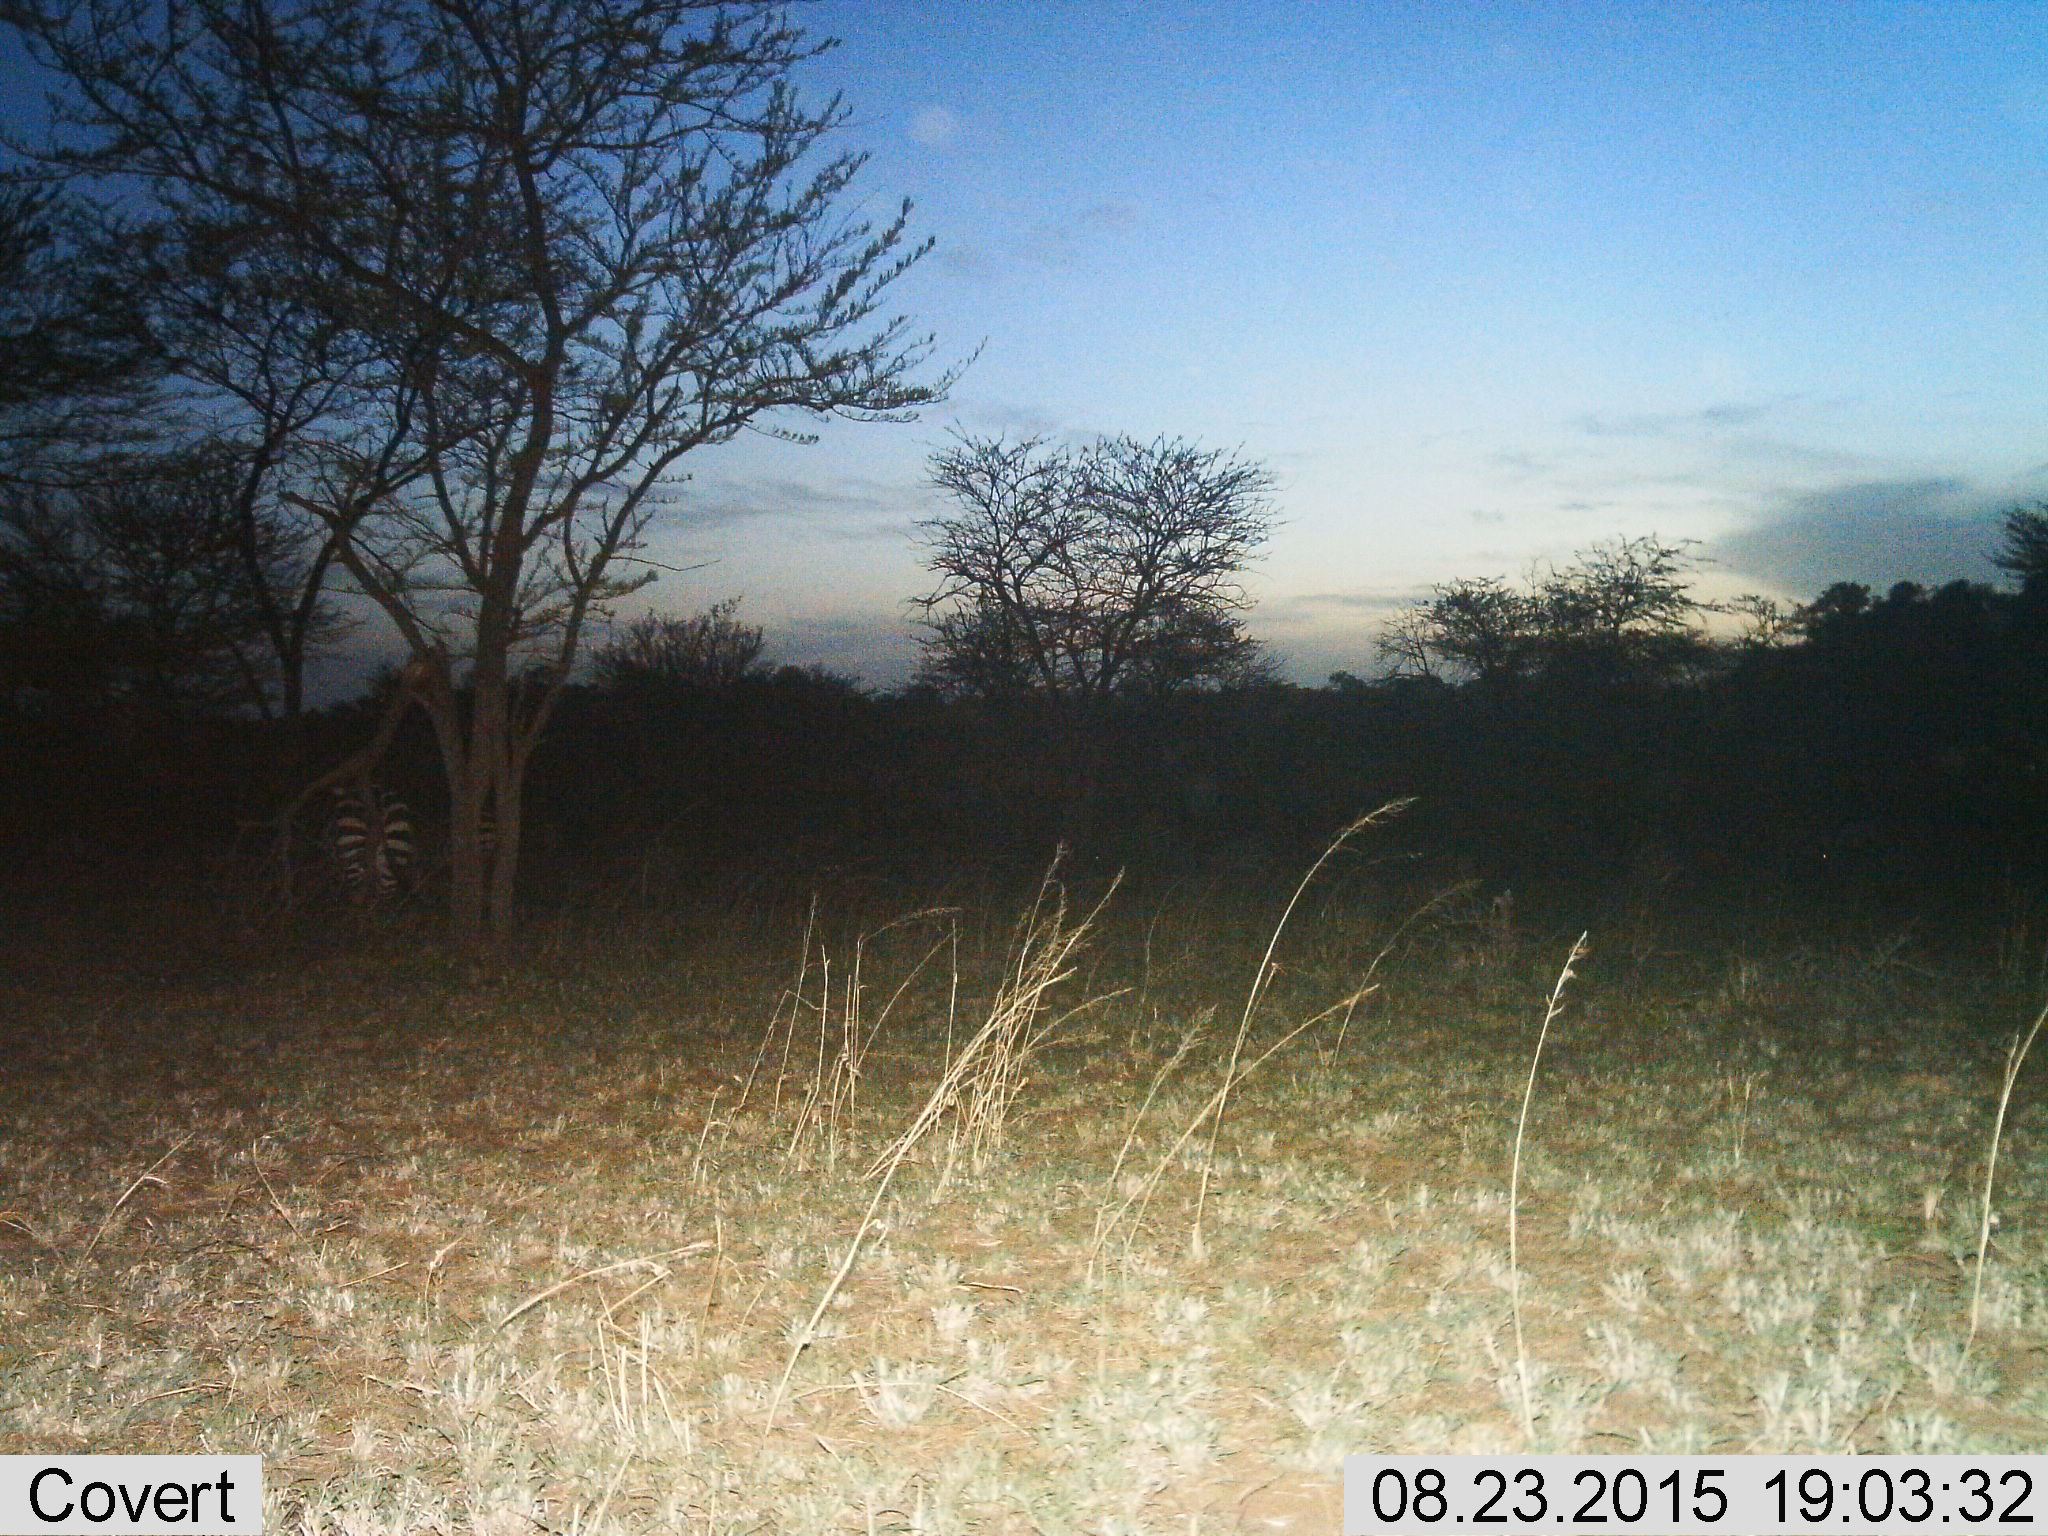

In [32]:
import random

def get_random_jpg_path(root_dir):
    # Define the image file extension for JPG files (case-insensitive)
    jpg_extension = '.jpg'
    jpg_paths = []
    
    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(jpg_extension):
                full_path = os.path.join(dirpath, filename)
                jpg_paths.append(full_path)
    
    # Return a random JPG image if any are found, else return None
    if jpg_paths:
        return random.choice(jpg_paths)
    else:
        return None

# Load a new image from the test data using Pillow
random_image_path = "/lakehouse/default/Files/images/test"
image = Image.open(get_random_jpg_path(random_image_path))
image


In [33]:
# Resize the image to a fixed size
resize_transform = transforms.Resize((224, 224))
image = resize_transform(image)

# Convert the image to a PyTorch tensor
tensor_transform = transforms.ToTensor()
tensor = tensor_transform(image)

# Add a batch dimension to the tensor
tensor = tensor.unsqueeze(0)

# Load the model from MLflow
model = mlflow.pytorch.load_model(model_uri)

# Set the model to evaluation mode
model.eval()

# Pass the tensor through the model to get the output
with torch.no_grad():
    output = model(tensor)

# Get the predicted class
_, predicted = torch.max(output.data, 1)

print(predicted.item())


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 44, Finished, Available, Finished)

2025/05/16 17:01:55 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


7


StatementMeta(, 6f98b7b2-74bd-4756-b6e5-2c5689df9a1a, 45, Finished, Available, Finished)